# Alpha diversity

Alpha diversity is the diversity **within** a sample/community. There are tons of different metrics for estimating alpha diversity, and only a small subset of the metrics will be presented here. **It is crucial that the dataset is not trimmed/pruned prior to calculating the alpha diversity.**

In [1]:
# Load phyloseq object and phyloseq package
library(phyloseq)
load("../data/physeq.RData")

# Contents
* [Observed richness](#o)
* [Shannon diversity](#s)
* [Phylogenetic diversity](#pd)
* [Plotting](#plot)
* [Statistics](#stats)

## Observed richness<a class="anchor" id="o"></a>
Richness is the number of different taxa in a community. Observed richness is therefore simply the observed number of different taxa in a sample, the simplest alpha diversity metric.

In R:

In [2]:
obs_rich <- estimate_richness(phy, measures = "Observed")
head(obs_rich)

,Observed
S1,28
S2,29
S3,27
S4,21
S5,25
S6,32


or with apply:

In [3]:
obs_rich <- apply(otu_table(phy), MARGIN = 2, function(x) sum(x > 0))
head(obs_rich)

S1 S2 S3 S4 S5 S6 
28 29 27 21 25 32

### Note on R code
*apply* in R does something on each row (MARGIN = 1) or column (MARGIN = 2) of a matrix. The otu_table(phy) we give as input contains counts of taxa with one column per sample. We therefore run the function on each sample. sum(x > 0) means that we find all counts that are larger than zero and we sum (count) those. This is the observed richness; the number of taxa that are present (abundance > 0) in a sample.

## Shannon diversity<a class="anchor" id="s"></a>
Shannon diversity (AKA Shannon entropy, AKA Shannon index), is a widely used alpha diversity metric. This metric is a combination of the richness (see above) and the evenness in sample, where the evenness is a measure of how equally abundant different taxa are in a sample. If all taxa have the same abundance then evenness is high, if one or few taxa dominates evenness is low.

Shannon diversity is calcualted as:
\begin{equation*}
H' = - \sum_{i=1}^R p_i ln \left( p_i \right) 
\end{equation*}

where *p*<sub>i</sub> is the relative abundance of taxa *i*. *ln* is the natural log, and R is the richness.

It was developed as a measure of information, and can be thought of as the uncertainty in whether two random individuals in a sample/community are similar. Therefore, the more different taxa are observed in a sample, and the more even their abundance is, the higher is the Shannon diversity. 

##### Effective number of taxa
From the Shannon diversity we can calculate the effective number of taxa, also called true diversity of order 1 (<sup>1</sup>D), as follows: <sup>1</sup>D=exp(H'). The <sup>1</sup>D can be seen as an abundance-corrected observed richness, based on the assumption that microbial communities with high evenness are effectively more diverse than communities with low evenness. The observed richness is true diversity of order 0 (<sup>0</sup>D), since it is ignoring relative abundance altogether. There are diveristy indices of higher orders than 1, which weigh the relative abundance more than Shannon diversity, effectively weighing the common (as opposed to the rare) taxa even more.

In R:

In [4]:
shannon <- estimate_richness(phy, measures = "Shannon")
head(shannon)

,Shannon
S1,2.174219
S2,1.465875
S3,1.590234
S4,1.499109
S5,1.658367
S6,1.608544


or directly with the formula above:

In [5]:
shannon <- apply(otu_table(phy), MARGIN = 2, function(x) -sum(x/sum(x)*log(x/sum(x)), na.rm = TRUE))
head(shannon)

S1       S2       S3       S4       S5       S6 
2.174219 1.465875 1.590234 1.499109 1.658367 1.608544

**Calculate effective number of taxa:**

In [6]:
D1 = exp(shannon)
head(D1)

S1       S2       S3       S4       S5       S6 
8.795316 4.331331 4.904898 4.477699 5.250731 4.995531

### Note on R code
As with the observed richness, we apply a function on each column (sample) of the otu_table. The function is the formula above, where x/sum(x) is a way to calculate the relative abundance. The log function will return NA for many taxa if their abundance is 0 (you cannot take the log of zero), and the na.rm = TRUE tells the function to ignore NA's in the final summation.

## Faith's phylogenetic diversity<a class="anchor" id="pd"></a>
Phylogenetic diversity (PD) is an alpha diversity metric which incorporates the phylogenetic tree of the taxa. Faith's PD is the sum of all the branch lengths that are connecting all taxa observed in the sample through the shortest path in the tree.

In the tree below, the cyan circles marks the taxa present in a given sample. The red line is the path connecting these taxa (usually the root is also included if present). Faith's PD of this sample is then the branch length spanned by the red path; that is, all the red horizontal lines.

![PD example](../img/PD.png)

In R:

In [7]:
# We need the picante package
library(picante)

Loading required package: ape
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: nlme


In [8]:
# PD: Phylogenetic Diversity
# SR: Species Richness (aka Observed richness)
fpd <- pd(t(otu_table(phy)), phy_tree(phy))
head(fpd)

,PD,SR
S1,4.005023,28
S2,4.976712,29
S3,4.024781,27
S4,3.291446,21
S5,3.594662,25
S6,4.978788,32


### Note on R code
The *pd* function of course needs our phylogenetic tree as input, but it also needs the otu_table to know which taxa are present in which samples. The *picante* package assumes that input tables have samples as rows, we therefore have to transpose our otu_table with the t() function.

# Plotting<a class="anchor" id="plot"></a>
We will use the ggplot2 package for plotting. 

In [9]:
library(ggplot2)

First, we will calculate observed richness and shannon diversity in one line, then we will add our sample metadata:

In [10]:
alpha <- estimate_richness(phy, measures = c("Observed", "Shannon"))
alpha <- merge(alpha, sample_data(phy), by = "row.names")

The *alpha* data.frame now looks like this:

In [11]:
head(alpha)

Row.names,Observed,Shannon,Patient,Time,Delivery
S1,28,2.174219,870,1m,Vaginal
S10,26,1.616258,ef5,1m,Vaginal
S100,72,3.024107,e4c,1y,Sectio
S101,88,3.203589,b6e,1y,Sectio
S102,76,3.104671,1f2,1y,Sectio
S103,76,2.817553,6fe,1y,Sectio


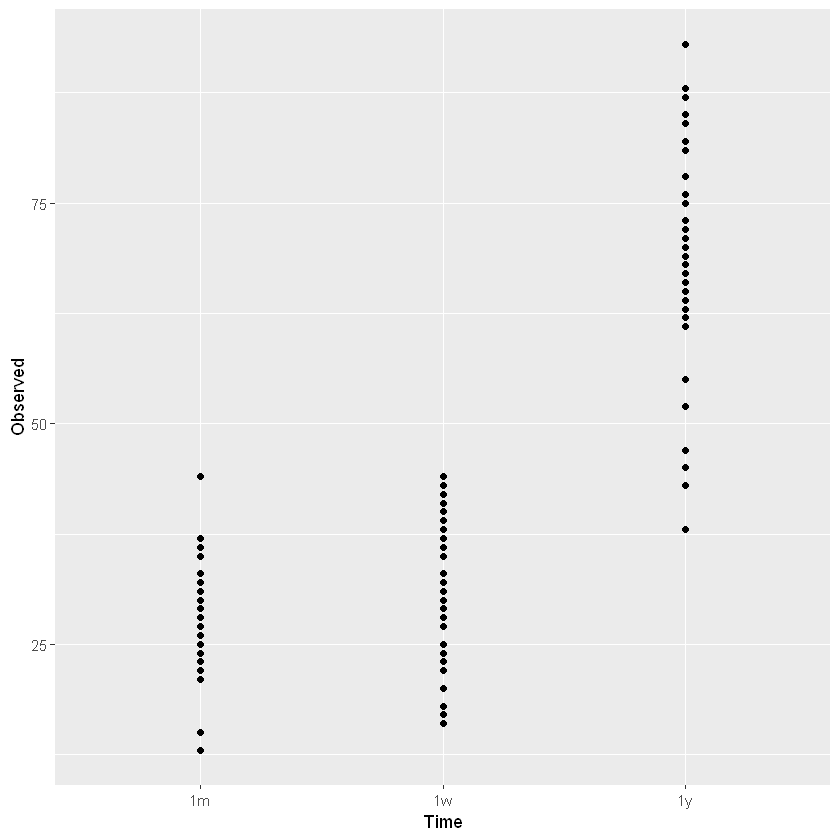

In [12]:
# Define plot
plot_alpha <- ggplot(alpha, aes(x = Time, y = Observed)) +
    geom_point()

# Show plot
plot_alpha

We can plot as boxplots with a black and white theme and with custom labels:

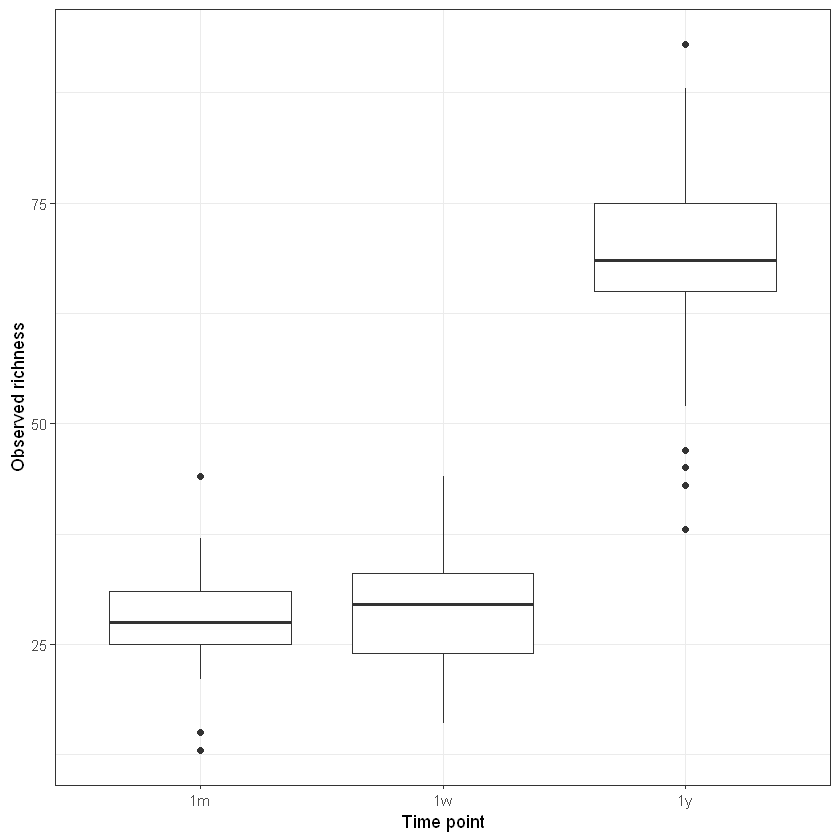

In [13]:
# Define plot
plot_alpha <- ggplot(alpha, aes(x = Time, y = Observed)) +
    theme_bw() +
    geom_boxplot() +
    xlab("Time point") +
    ylab("Observed richness")
    
# Show plot
plot_alpha

# Statistics<a class="anchor" id="stats"></a>
From the plots above it appears as the richness is higher at 1 year (1y) than the other time points. Can this be supported statistically?

To test if the richness differs between the time points we would run an ANOVA.

Let's first make Time into a factor, and set the levels chronologically:

In [14]:
alpha$Time <- factor(alpha$Time, levels = c("1w", "1m", "1y"))

Then we need to define the anova model:

**A note on notation:** The left-hand side of the formula (y ~ x) is the response (AKA dependent variable) and the right-hand side are the features (AKA independent variables, AKA covariates)

In [15]:
model <- aov(Observed ~ Time, data = alpha)

We can then get a summary of our model, and see that the time variable is highly significant.

In [16]:
summary(model)

             Df Sum Sq Mean Sq F value Pr(>F)    
Time          2  53803   26901     400 <2e-16 ***
Residuals   147   9887      67                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We can also run the Tukey's Honest Significant Different test as a post-hoc test to compare all time points pairwise:

In [17]:
TukeyHSD(model)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ Time, data = alpha)

$Time
       diff       lwr       upr     p adj
1m-1w -1.66 -5.543551  2.223551 0.5704442
1y-1w 39.32 35.436449 43.203551 0.0000000
1y-1m 40.98 37.096449 44.863551 0.0000000


This result fits with what we see in plot. The richness at 1 year is higher than at 1 month and 1 week. 

The left-hand side of the output are the pairwise comparisons. Diff is the difference in means. Lwr and upr are lower and upper 95% confidence intervals (of the difference). p adj is the adjusted p-value.

## Library size
If the dataset is not rarefied (see [notebook on rarefaction](https://microucph.github.io/amplicon_data_analysis/html/compositionality.html) for details), we should include the library size (the total number of reads in a given sample) in the model, as this could have substantial effect on the alpha diversity estimation. As the library size is a continuous variable we should run a linear model instead of an anova.

In [18]:
# First we include the library size in our 'alpha' data.frame
libSize <- data.frame(LibSize = sample_sums(phy))
alpha <- merge(alpha, libSize, by.x = "Row.names", by.y = "row.names")

In [19]:
# Then define the new model
model2 <- lm(Observed ~ Time + log10(LibSize), data = alpha)

In this linear model the time variable is split in three so-called dummy variables, one for each level, the first being the intercept. The interpretation here is that: the intercept represents the 1 week time point. The estimate next to Time1m shows that the richness at 1 month is 1.4 lower than at 1 week. The estimate next to Time1y shows that the richness at 1 year is 39.7 higher than at 1 week. The difference between 1 year and 1 week is significant (p < 2e-16), but not the difference between 1 week and 1 month (p = 0.3195).
Furthermore, the log10(LibSize) variable shows that every time the library size gets 10 times larger the richness increases by 9.6, and this is significant (p = 2.14e-12).

In [20]:
summary(model2)


Call:
lm(formula = Observed ~ Time + log10(LibSize), data = alpha)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.8529  -4.2637  -0.4127   3.6926  22.4072 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -14.799      5.847  -2.531   0.0124 *  
Time1m           -1.388      1.390  -0.999   0.3195    
Time1y           39.680      1.390  28.549  < 2e-16 ***
log10(LibSize)    9.573      1.247   7.678 2.14e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.946 on 146 degrees of freedom
Multiple R-squared:  0.8894,	Adjusted R-squared:  0.8871 
F-statistic: 391.4 on 3 and 146 DF,  p-value: < 2.2e-16


If we want to compare 1 month with 1 year, we can test all pairwise time points, as with the TukeyHSD above. We just need to use another function from the multcomp pacage.

In [21]:
# Load package
library(multcomp)

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: 'TH.data'

The following object is masked from 'package:MASS':

    geyser



In [22]:
# Run Tukey contrasts on the time variable on our model2
summary(glht(model2, linfct=mcp(Time="Tukey")))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = Observed ~ Time + log10(LibSize), data = alpha)

Linear Hypotheses:
             Estimate Std. Error t value Pr(>|t|)    
1m - 1w == 0   -1.388      1.390  -0.999    0.579    
1y - 1w == 0   39.680      1.390  28.549   <1e-04 ***
1y - 1m == 0   41.068      1.389  29.563   <1e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)


This result agrees with our first model; 1 month and 1 week do not have different richness, and at 1 year the richness is higher.

## Repeated measures (mixed-effect model)
In this dataset we have repeated measurements from the same patients; we have samples from the same children at 1 week, 1 month, and 1 year. It is therefore best practive to take this into account in our statistical model. This analysis is outside the scope of this notebook, but more information can be found in the [Coding Club](https://ourcodingclub.github.io/tutorials/mixed-models/).